## Intro

Involving in a full-time Airbnb business needs to be carefully organized, starting from understanding comprehensive rental agreement, covering liability and waivers, contracting with a reliable cleaner and caretaker and communicating with guests. For your hard effort to pay off, being strategic and making the right decision from the start of your airbnb business is important.

Here, I used data from Airbnb which covers reviews, hosts, location, price, occupation rate to help you out to choose the right location, room types and the number of competitors for rental services. Any potential airbnb host who wants guide in diving into short rental service should read this post. Don’t beat the dead horse and make your decision based on real data.

## Overview

### 1. Data Preprocessing
### 2. Data Exploration
    Question 1: Which neighborhood in Seattle should potential hosts look for?
    Question 2: Popular roomtypes?
    Question 3: Number of Competitors?
    Extra Analysis: Word Frequency Analysis of neighborhood and room reviews
### 3. Conclusion and Discussion

In [209]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import json

from textblob import TextBlob
from wordcloud import WordCloud
from folium.plugins import MarkerCluster
from folium import Marker
import branca

#set options
%matplotlib inline 
pd.set_option('display.max_columns', None)

### 1. Data Preprocessing

In [2]:
#import data
listings_df = pd.read_csv('listings.csv')
reviews_df = pd.read_csv('reviews.csv')
date_df = pd.read_csv('calendar.csv')

#view data
listings_df.head(3)
reviews_df.head(3)
date_df.head(3)

#listings_df info
listings_df.info()
listings_df.describe()

#date_df info
date_df.info()
date_df.describe()

#reviews_df info
reviews_df.info()
reviews_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

listing_id            id   reviewer_id
count  8.484900e+04  8.484900e+04  8.484900e+04
mean   3.005067e+06  3.058765e+07  1.701301e+07
std    2.472877e+06  1.636613e+07  1.353704e+07
min    4.291000e+03  3.721000e+03  1.500000e+01
25%    7.946330e+05  1.725127e+07  5.053141e+06
50%    2.488228e+06  3.228809e+07  1.413476e+07
75%    4.694479e+06  4.457648e+07  2.762402e+07
max    1.024814e+07  5.873651e+07  5.281274e+07

In [3]:
#listings_df missing values

listings_df.isna().sum().sort_values(ascending= False)

#drop columns that has more than half NAN values (#miss_na > 1900)
listings_df.drop(columns = ['license', 'square_feet', 'monthly_price', 'security_deposit'], inplace = True)

#drop unnecessary columns for this analysis (url columns)
listings_df.drop(columns = ['thumbnail_url', 'medium_url', 'xl_picture_url', 
                            'picture_url', 'host_url', "host_thumbnail_url", 
                            'host_picture_url'], inplace = True)

#listings_df duplicate values
listings_df.duplicated().sum() #no duplicates

0

In [5]:
#date_df missing values
date_df.isna().sum().sort_values(ascending= False)
## price has 459028 missing values - when available is False - no need to clean

#date_df duplicate values
date_df.duplicated().sum() ##no duplicates

0

In [6]:
#reviews_df missing values
reviews_df.isna().sum().sort_values(ascending= False)

#drop rows that has no comments (n = 18)
reviews_df.dropna(inplace= True)

#reviews_df duplicate values
reviews_df.duplicated().sum() ##no duplicates

0

In [21]:
#date_df: added price_clean and available_clean to dataframe

# get rid of the dollar sign and change data type to float 
date_df['price_clean'] = date_df['price'].str.replace('$', '').str.replace(',','')
date_df = date_df.astype({'price_clean':'float'})

#change t/f to Boolean
date_df['available_clean'] = date_df['available'].replace('t', True).replace('f', False)

date_df.head(1)

C:\Users\younk\AppData\Local\Temp\ipykernel_8360\1960032847.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  date_df['price_clean'] = date_df['price'].str.replace('$', '').str.replace(',','')


listing_id        date available   price  price_clean  available_clean
0      241032  2016-01-04         t  $85.00         85.0             True

In [22]:
#listings_df: added price_clean and available_clean to dataframe
listings_df['price_clean_list'] = listings_df['price'].str.replace('$', '').str.replace(',','')
listings_df = listings_df.astype({'price_clean_list':'float'})

#description text data clean
listings_df['description_clean'] = listings_df['description'].str.replace('?', '').str.replace('/', '').str.replace('"','').str.replace('.','').str.replace(',', '')

#drop columns that will be used
listings_df.dropna(subset = ['zipcode'],  inplace = True)

listings_df.head(1)

C:\Users\younk\AppData\Local\Temp\ipykernel_8360\2570751711.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listings_df['price_clean_list'] = listings_df['price'].str.replace('$', '').str.replace(',','')
C:\Users\younk\AppData\Local\Temp\ipykernel_8360\2570751711.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listings_df['description_clean'] = listings_df['description'].str.replace('?', '').str.replace('/', '').str.replace('"','').str.replace('.','').str.replace(',', '')


id                          listing_url       scrape_id last_scraped  \
0  241032  https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   

                           name summary  \
0  Stylish Queen Anne Apartment     NaN   

                                               space  \
0  Make your self at home in this charming one-be...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   

  neighborhood_overview notes transit  host_id host_name  host_since  \
0                   NaN   NaN     NaN   956883     Maija  2011-08-11   

                        host_location  \
0  Seattle, Washington, United States   

                                          host_about  host_response_time  \
0  I am an artist, interior designer, and run a s...  within a few hours   

  host_response_rate host_acceptance_rate host_is_superhost  \
0                96%                 100%                 f   

  host_neighbourhood  host_listings_count  host_total_listings_count  \
0         Queen Anne                  3.0                        3.0   

                     host_verifications host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'kba']                    t   

  host_identity_verified                                         street  \
0                      t  Gilman Dr W, Seattle, WA 98119, United States   

  neighbourhood neighbourhood_cleansed neighbourhood_group_cleansed     city  \
0    Queen Anne        West Queen Anne                   Queen Anne  Seattle   

  state zipcode   market smart_location country_code        country  \
0    WA   98119  Seattle    Seattle, WA           US  United States   

    latitude   longitude is_location_exact property_type        room_type  \
0  47.636289 -122.371025                 t     Apartment  Entire home/apt   

   accommodates  bathrooms  bedrooms  beds  bed_type  \
0             4        1.0       1.0   1.0  Real Bed   

                                           amenities   price weekly_price  \
0  {TV,"Cable TV",Internet,"Wireless Internet","A...  $85.00          NaN   

  cleaning_fee  guests_included extra_people  minimum_nights  maximum_nights  \
0          NaN                2        $5.00               1             365   

  calendar_updated has_availability  availability_30  availability_60  \
0      4 weeks ago                t               14               41   

   availability_90  availability_365 calendar_last_scraped  number_of_reviews  \
0               71               346            2016-01-04                207   

  first_review last_review  review_scores_rating  review_scores_accuracy  \
0   2011-11-01  2016-01-02                  95.0                    10.0   

   review_scores_cleanliness  review_scores_checkin  \
0                       10.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                     9.0                 10.0   

  requires_license jurisdiction_names instant_bookable cancellation_policy  \
0                f         WASHINGTON                f            moderate   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   

   calculated_host_listings_count  reviews_per_month  listing_id  \
0                               2               4.07      241032   

   price_clean_list                                  description_clean  
0              85.0  Make your self at home in this charming one-be...

In [23]:
#merge two datasets 

#listings_review_df: listings_df and reviews_df
listings_df['listing_id'] = listings_df['id']
listings_review_df = reviews_df[['listing_id', 'comments']].merge(listings_df[['listing_id', 'neighbourhood_group_cleansed']], on = 'listing_id', suffixes=('_1', '_2'))
listings_review_df.columns = ['listing_id', 'comments', 'neighbourhood']

#listings_date_df: listings_df and date_df
listings_date_df = date_df.merge(listings_df, on = 'listing_id', suffixes=('_1', '_2'))

## 2. Data Exploration 

### 2-1: Which neighborhood in Seattle should potential hosts look for? 

1. Monthly number price and occupations by neighborhood region
2. Use additional data (e.g., housing price) to provide the potential host with insights 
3. Visualize potentially lucrative areas via map and geo-json data of Seattle

#### 2-1-1. Monthly number price and occupations by neighborhood region

In [122]:
##helper function

# monthly price and occupation rate by neighborhood 
def get_monthly_df():
    listings_date_df['date'] = pd.to_datetime(listings_date_df['date'])
    monthly_mean = listings_date_df[['date', 'review_scores_location', 'available_clean', 'price_clean','neighbourhood_group_cleansed']].groupby([pd.Grouper(key='date',freq='M'), 'neighbourhood_group_cleansed']).mean()
    monthly_mean.reset_index(inplace = True)
    monthly_mean.columns = ['date', 'neighborhood', 'location score', 'availability', 'price']
    monthly_mean['occupation rate'] = 1 - monthly_mean['availability']
    return monthly_mean

occupation_average = monthly_data.groupby('neighborhood').mean().reset_index()
occupation_average['location score'].describe()
merged = monthly_data[['neighborhood', 'date', 'occupation rate']].merge(occupation_average[['neighborhood', 'location score']], on = 'neighborhood')

merged[merged['location score']> 9.75]

neighborhood       date  occupation rate  location score
0         Ballard 2016-01-31         0.484248        9.770833
1         Ballard 2016-02-29         0.387291        9.770833
2         Ballard 2016-03-31         0.316805        9.770833
3         Ballard 2016-04-30         0.332314        9.770833
4         Ballard 2016-05-31         0.297788        9.770833
5         Ballard 2016-06-30         0.268268        9.770833
6         Ballard 2016-07-31         0.330892        9.770833
7         Ballard 2016-08-31         0.296943        9.770833
8         Ballard 2016-09-30         0.275400        9.770833
9         Ballard 2016-10-31         0.255670        9.770833
10        Ballard 2016-11-30         0.235517        9.770833
11        Ballard 2016-12-31         0.217495        9.770833
12        Ballard 2017-01-31         0.222707        9.770833
26   Capitol Hill 2016-01-31         0.470417        9.825328
27   Capitol Hill 2016-02-29         0.370217        9.825328
28   Capitol Hill 2016-03-31         0.337539        9.825328
29   Capitol Hill 2016-04-30         0.385900        9.825328
30   Capitol Hill 2016-05-31         0.372709        9.825328
31   Capitol Hill 2016-06-30         0.358171        9.825328
32   Capitol Hill 2016-07-31         0.398002        9.825328
33   Capitol Hill 2016-08-31         0.384014        9.825328
34   Capitol Hill 2016-09-30         0.346136        9.825328
35   Capitol Hill 2016-10-31         0.318584        9.825328
36   Capitol Hill 2016-11-30         0.301357        9.825328
37   Capitol Hill 2016-12-31         0.275421        9.825328
38   Capitol Hill 2017-01-31         0.243363        9.825328
78       Downtown 2016-01-31         0.408385        9.771429
79       Downtown 2016-02-29         0.291506        9.771429
80       Downtown 2016-03-31         0.251235        9.771429
81       Downtown 2016-04-30         0.306049        9.771429
82       Downtown 2016-05-31         0.316849        9.771429
83       Downtown 2016-06-30         0.353875        9.771429
84       Downtown 2016-07-31         0.418745        9.771429
85       Downtown 2016-08-31         0.405025        9.771429
86       Downtown 2016-09-30         0.388784        9.771429
87       Downtown 2016-10-31         0.367705        9.771429
88       Downtown 2016-11-30         0.354505        9.771429
89       Downtown 2016-12-31         0.330508        9.771429
90       Downtown 2017-01-31         0.318526        9.771429
208  West Seattle 2016-01-31         0.413265        9.765432
209  West Seattle 2016-02-29         0.301682        9.765432
210  West Seattle 2016-03-31         0.251232        9.765432
211  West Seattle 2016-04-30         0.297865        9.765432
212  West Seattle 2016-05-31         0.293819        9.765432
213  West Seattle 2016-06-30         0.275534        9.765432
214  West Seattle 2016-07-31         0.331321        9.765432
215  West Seattle 2016-08-31         0.325123        9.765432
216  West Seattle 2016-09-30         0.294910        9.765432
217  West Seattle 2016-10-31         0.285396        9.765432
218  West Seattle 2016-11-30         0.274220        9.765432
219  West Seattle 2016-12-31         0.253774        9.765432
220  West Seattle 2017-01-31         0.266010        9.765432

In [132]:
def monthly_rate(data, y_value, z_value, z_range1, z_range2, z_range3, y_label):
    #range 1 to 4: highest to lowest z_value
    '''
    get monthly price/occupation rate by neighborhood & visulize. 

    '''
    
    fig, axes = plt.subplots(2, 2, sharey = True, figsize = (40, 40))
    
    occupation_average = data.groupby('neighborhood').mean().reset_index()
    merged = data[['neighborhood', 'date', y_value]].merge(occupation_average[['neighborhood', z_value]], on = 'neighborhood')
    
    sns.lineplot(x ='date', y = y_value, hue = 'neighborhood', data = merged[merged[z_value] > z_range1], ax=axes[0, 0])
    sns.lineplot(x ='date', y = y_value, hue = 'neighborhood', data = merged[(merged[z_value] <= z_range1) & (merged[z_value] > z_range2)], ax = axes[0, 1])
    sns.lineplot(x ='date', y = y_value, hue = 'neighborhood', data = merged[(merged[z_value] <= z_range2) & (merged[z_value] > z_range3)], ax = axes[1, 0])
    sns.lineplot(x ='date', y = y_value, hue = 'neighborhood', data = merged[merged[z_value] <= z_range3], ax=axes[1, 1])

    axes[0, 0].set_title('Airbnb Price of neighborhood with over 75% quantile {}'.format(z_value), fontsize = 20)
    axes[0, 0].set_ylabel(y_label, fontsize = 18)
    axes[0, 0].set_xlabel('Date', fontsize = 18)
    
    axes[0, 1].set_title('Airbnb Price of neighborhood with 50-75% quantile {}'.format(z_value), fontsize = 20)
    
    axes[1, 0].set_title('Airbnb Price of neighborhood with 25-50% quantile {}'.format(z_value), fontsize = 20)
    axes[1, 0].set_ylabel(y_label, fontsize = 18)
    axes[1, 0].set_xlabel('Date', fontsize = 18)
    
    axes[1, 1].set_title('Airbnb Price of neighborhood under 25% quantile {}'.format(z_value), fontsize = 20)
    
    leg0 = axes[0, 0].legend(loc = 'best', fontsize = 18)
    leg1 = axes[0, 1].legend(loc = 'best', fontsize = 18)
    leg2 = axes[1, 0].legend(loc = 'best', fontsize = 18)
    leg3 = axes[1, 1].legend(loc = 'best', fontsize = 18)

    leg0.set_title('Neighborhood',prop={'size':18})
    leg1.set_title('Neighborhood',prop={'size':18})
    leg2.set_title('Neighborhood',prop={'size':18})
    leg3.set_title('Neighborhood',prop={'size':18})

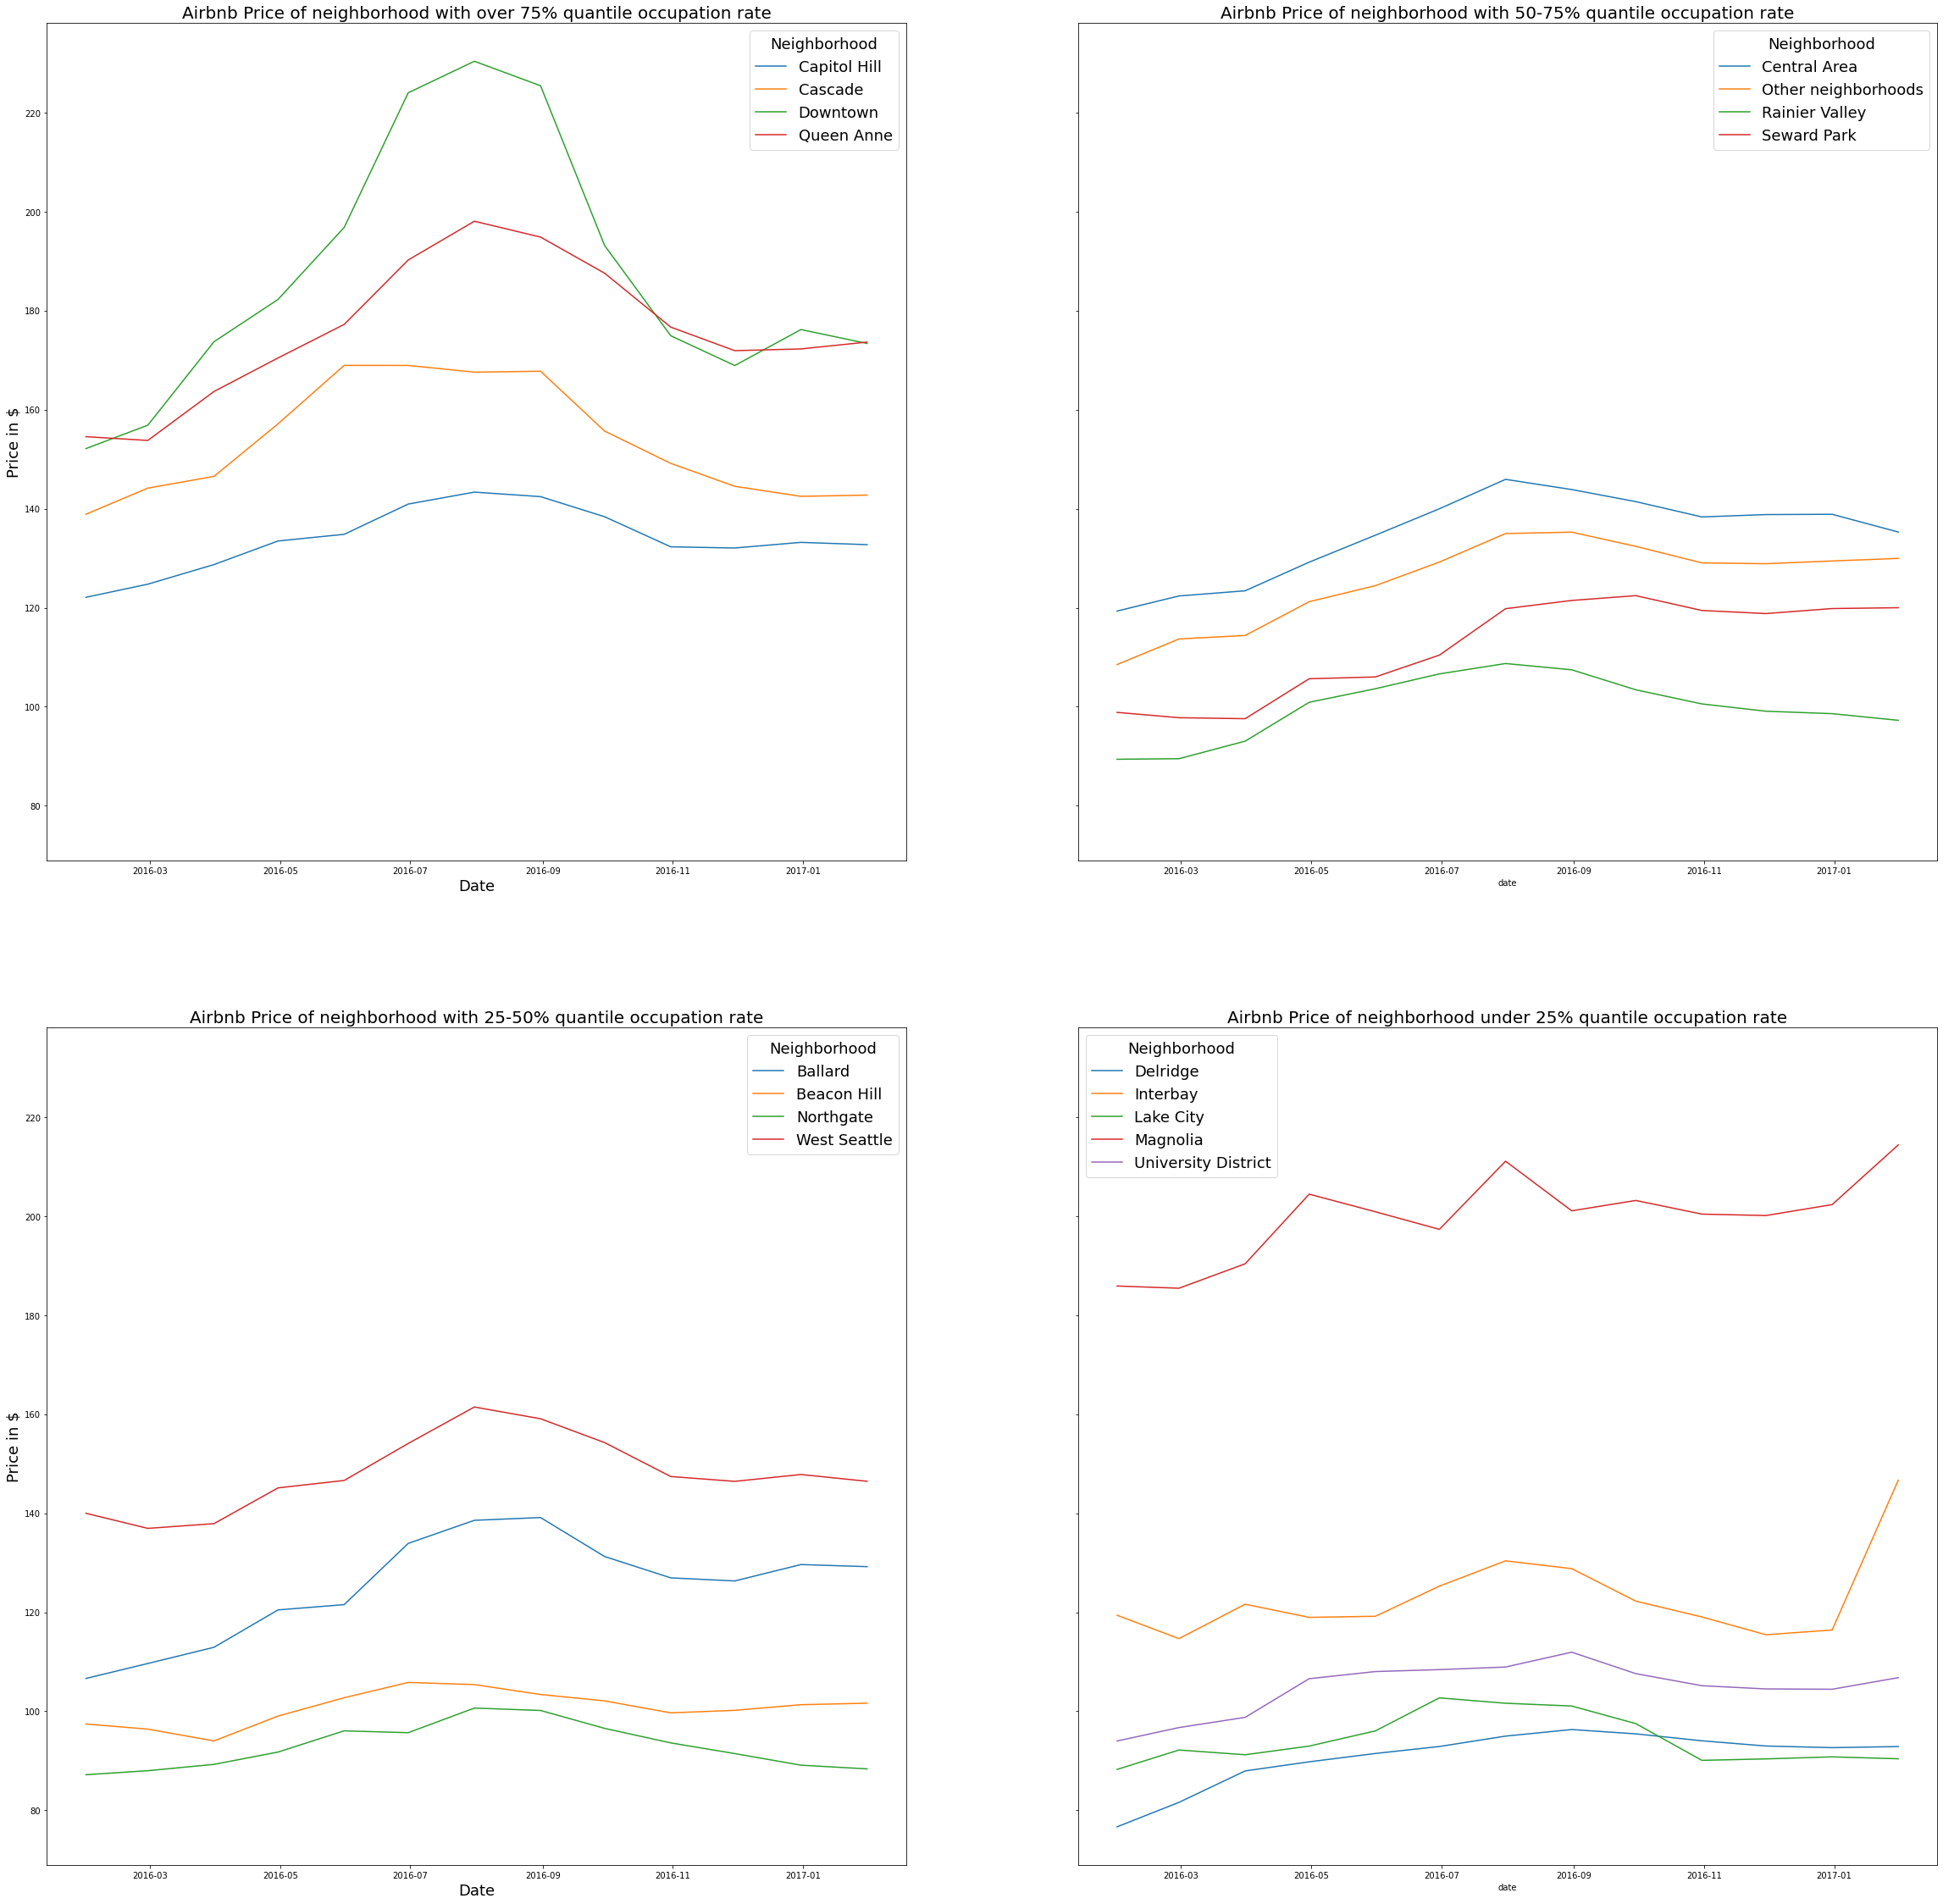

In [222]:
# results: monthly price
monthly_data = get_monthly_df()
monthly_rate(monthly_data, 'price', 'occupation rate', .33, .31, .26, 'Price in $')
plt.savefig("figure1.png")

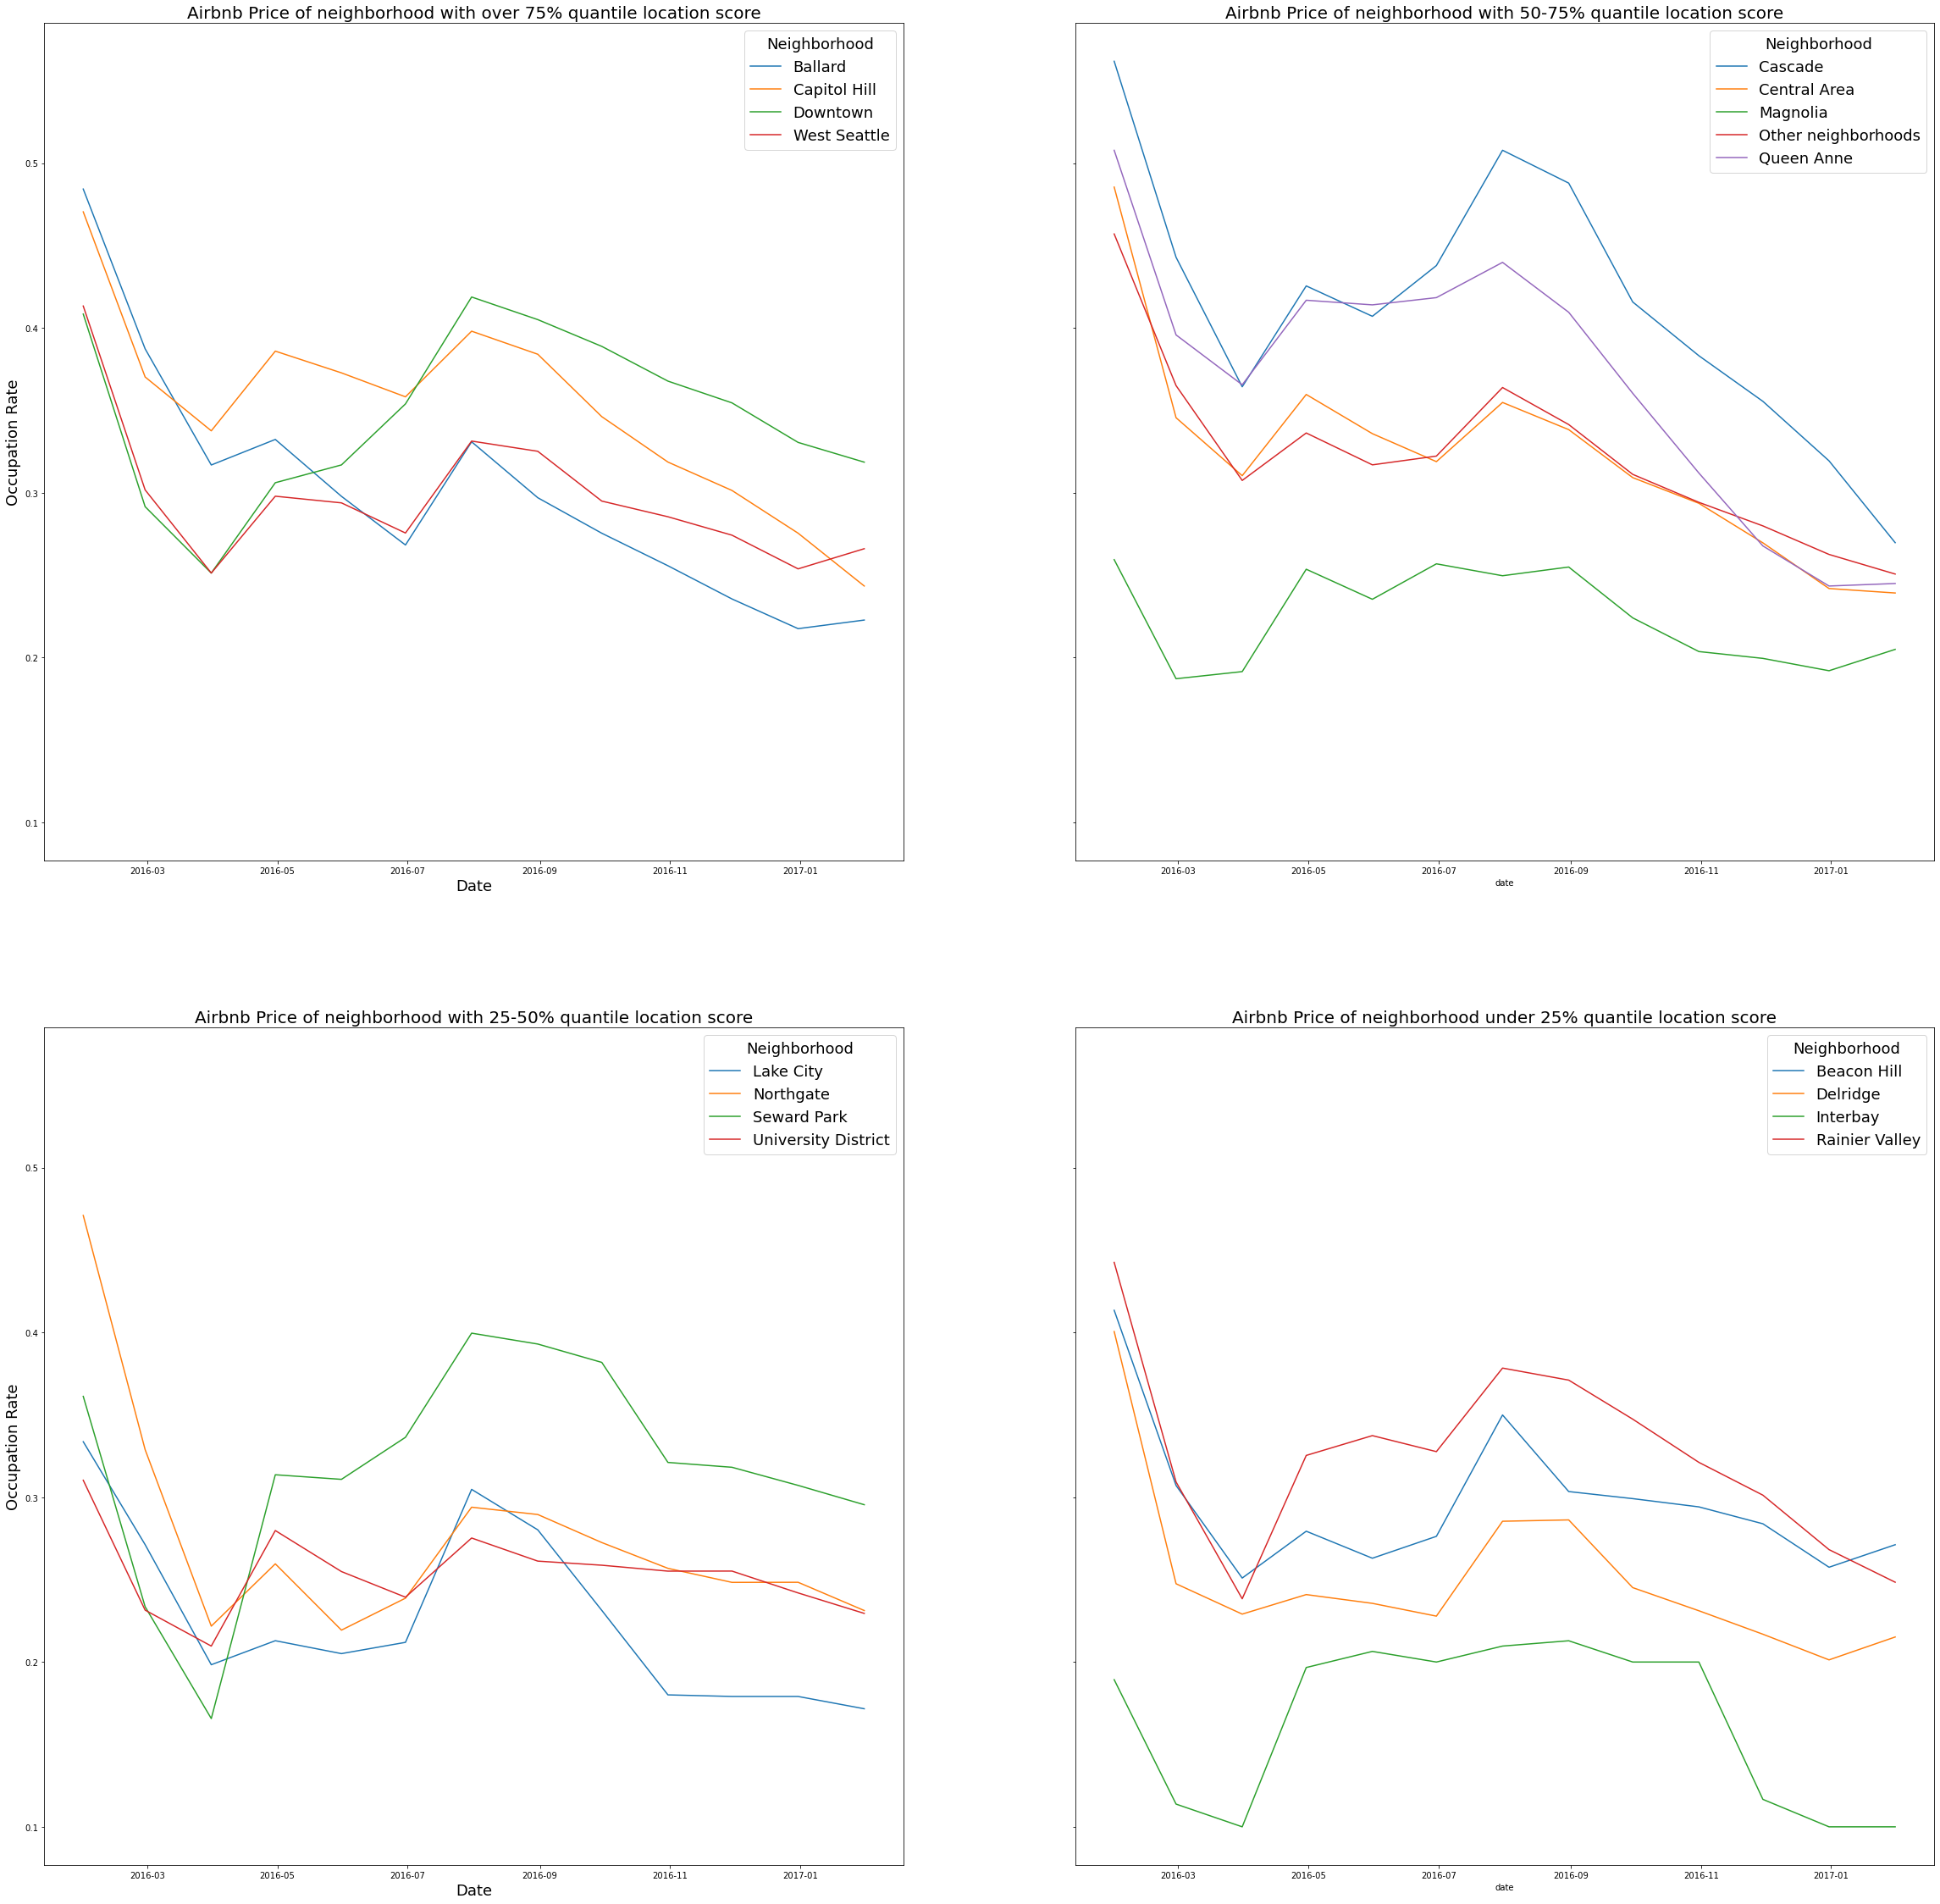

In [223]:
# results: monthly occupation rate
monthly_data = get_monthly_df()
monthly_rate(monthly_data, 'occupation rate', 'location score', 9.75, 9.48, 9.25, 'Occupation Rate')
plt.savefig("figure2.png")

#### 2-1-2. Calculating annual revenue vs. cost of house

**[House Price Index from 
Federal Housing Finance Agency]**
The HPI measures the price development of dwellings sold to households. The price development of dwellings is based on the selling price. This is the price paid for the dwelling, including the land on which the property stands. The selling price does not include additional costs such as notary fees, estate agent fees and property assessment costs. 

In [135]:
#importing hpi data 
hpi = pd.read_csv('seattle_hpi.csv')

hpi.head(2)
#cleaning hpi data 
hpi.columns = ['zipcode', 'year', 'annual change' ,'hpi', 'hpi1990' ,'hpi2000','un1', 'un2']
hpi = hpi[['zipcode', 'year', 'hpi', 'hpi2000']]
hpi['zipcode'] = hpi['zipcode'].astype('str')

#pull out the necessary hpi data (seattle zip code)
ziplist = listings_df['zipcode'].unique().tolist()
seattle_hpi = hpi.loc[(hpi['zipcode'].isin(ziplist)  & (hpi['year'] == 2016))].reset_index(drop= True)
seattle_hpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   zipcode  23 non-null     object
 1   year     23 non-null     int64 
 2   hpi      23 non-null     object
 3   hpi2000  23 non-null     object
dtypes: int64(1), object(3)
memory usage: 864.0+ bytes


In [225]:
#calculate the revenue/cost index
def revenue_cost():  
    '''to find out the appropriate cost vs. benefit (average profit for airbnb-ing the place)'''
    listings_zipcode_grouped_df = listings_df[['guests_included', 'accommodates', 'price_clean_list', 'neighbourhood_group_cleansed',
                            'zipcode', 'reviews_per_month', 'latitude', 'longitude']].groupby('zipcode').mean().reset_index()
    
    zipcode_listings_hpi_df = listings_zipcode_grouped_df.merge(seattle_hpi, on = 'zipcode', how = 'inner')
    zipcode_listings_hpi_df['hpi2000'] = zipcode_listings_hpi_df['hpi2000'].astype('float')
    zipcode_listings_hpi_df['hpi'] = zipcode_listings_hpi_df['hpi'].astype('float')

    zipcode_listings_hpi_df['rev_index'] = zipcode_listings_hpi_df['price_clean_list']*zipcode_listings_hpi_df['reviews_per_month']/zipcode_listings_hpi_df['hpi2000']
    #rev_index = considering the hpi, the revenue (estimated via monthly price and # of reviews)
    return zipcode_listings_hpi_df[['zipcode', 'hpi2000', 'hpi', 'price_clean_list', 'reviews_per_month', 'rev_index', 'latitude', 'longitude']]

In [226]:
#results: benefit vs cost by region 
revenue_cost()

zipcode  hpi2000      hpi  price_clean_list  reviews_per_month  rev_index  \
0    98102   218.97   702.20        127.103245           2.067263   1.199963   
1    98103   226.56  1789.21        124.149746           1.804940   0.989066   
2    98105   225.54  2202.84        107.111111           1.606816   0.763092   
3    98106   213.45   989.85         82.103448           2.012745   0.774202   
4    98107   239.67  1539.06        130.238889           2.587434   1.406036   
5    98108   207.42   895.75         83.875000           2.809583   1.136119   
6    98109   238.27  1235.82        150.247525           2.039259   1.285909   
7    98112   216.35  1529.17        135.437126           1.970725   1.233692   
8    98115   222.44  1786.53        112.129213           1.738859   0.876537   
9    98116   208.97  1703.55        145.348214           1.909890   1.328416   
10   98117   228.92  1732.03        111.262195           2.275072   1.105756   
11   98118   204.99  1112.94         93.798701           2.566791   1.174504   
12   98119   219.19  1555.37        166.377622           2.206555   1.674900   
13   98122   225.16  1368.33        132.492857           2.097967   1.234525   
14   98125   209.64  1405.75         88.577465           1.453390   0.614089   
15   98126   218.27  1202.93        122.730159           1.936042   1.088609   
16   98133   207.52  1210.99         86.282609           1.348889   0.560841   
17   98136   209.82  1503.54        137.909091           2.057778   1.352522   
18   98144   218.55  1469.98        105.395000           2.220714   1.070932   
19   98146   193.80  1106.12         97.800000           1.030000   0.519783   
20   98177   200.78  1238.75         98.842105           2.010667   0.989832   
21   98178   178.35   861.64         94.428571           3.190000   1.688966   
22   98199   214.82  1516.91        172.393939           1.585098   1.272048   

     latitude   longitude  
0   47.627148 -122.321894  
1   47.666743 -122.343787  
2   47.663647 -122.308326  
3   47.542948 -122.359320  
4   47.668170 -122.374383  
5   47.552909 -122.306374  
6   47.630607 -122.348178  
7   47.626233 -122.301791  
8   47.684500 -122.305607  
9   47.573340 -122.396152  
10  47.685527 -122.375934  
11  47.547902 -122.275858  
12  47.636019 -122.366312  
13  47.612331 -122.309445  
14  47.715143 -122.305406  
15  47.558499 -122.375825  
16  47.711072 -122.347549  
17  47.541044 -122.387911  
18  47.586711 -122.302805  
19  47.510117 -122.383805  
20  47.710184 -122.366475  
21  47.509101 -122.255297  
22  47.648345 -122.394907

#### 2-1-3. Visualize potentially lucrative areas on Seattle Map

In [142]:
# get the lat-long avg
lat = listings_df['latitude'].mean()
long = listings_df['longitude'].mean()
lat, long

(47.628948426187776, -122.3330882798613)

In [143]:
#import geo_json data of Seattle Area
geo_path = 'seattle_zipcodes.json'
geo_json = json.load(open(geo_path, encoding = 'utf-8'))

In [144]:
ziplist = listings_df['zipcode'].unique().tolist()
len(ziplist)

28

In [145]:
inziplist = []
for ft in geo_json['features']:
    if ft['properties']['ZIPCODE'] in ziplist:
        inziplist.append(ft)
        ft['properties']['ZIPCODE']

print(len(inziplist)) 

27


In [146]:
#new zip_json
new_zip_json = {}
new_zip_json['type'] = 'FeatureCollection'
new_zip_json['features'] = inziplist
new_zip_json  = json.dumps(new_zip_json)

In [244]:
#draw map of revenue index by zipcode 
m = folium.Map([lat, long])
revenue_cost_df = revenue_cost()


folium.Choropleth(
    geo_data=new_zip_json,
    name='choropleth',
    data= revenue_cost_df,
    columns=['zipcode', 'rev_index'],
    key_on='feature.properties.ZIPCODE',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    nan_fill_color='grey',
    nan_fill_opacity=0.4,
    legend_name='Airbnb revenue index'
).add_to(m)

mc = MarkerCluster()
for _, row in revenue_cost_df.iterrows():
    mc.add_child(    
        Marker(location = [row['latitude'], row['longitude']],
               popup='Zipcode {}'.format(row['zipcode'])
              )
    )
    
m.add_child(mc)


m

### Question 2: Popular roomtypes?

#### 2-2-1. Average number of rooms and accomodates by region

In [230]:
#select columns and merge necessary datasets for analysis 
room_df = listings_date_df[['latitude', 'longitude', 'zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'date', 'available_clean']].reset_index(drop = True)

#categorize by number of accomodates
room_df['date'] = pd.to_datetime(room_df['date'])
bins = [0, 2, 5, 9, np.inf]
names = ['1-2', '3-5', '6-9', '10-15']
room_df['MaxPeopleRange'] = pd.cut(room_df['accommodates'], bins, labels=names)

In [231]:
#average accomodates by zipcode 
m = folium.Map([lat, long], zoom_start= 10.5)

folium.Choropleth(
    geo_data=new_zip_json,
    name='choropleth',
    data= room_df,
    columns=['zipcode', 'accommodates'],
    key_on='feature.properties.ZIPCODE',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    nan_fill_color='grey',
    nan_fill_opacity=0.4,
    legend_name='Average number of accomodates by region',
).add_to(m)

m

In [232]:
#average number of bedrooms by zipcode

m = folium.Map([lat, long], zoom_start= 10.5)

folium.Choropleth(
    geo_data=new_zip_json,
    name='choropleth',
    data= room_df,
    columns=['zipcode', 'bedrooms'],
    key_on='feature.properties.ZIPCODE',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    nan_fill_color='grey',
    nan_fill_opacity=0.4,
    legend_name='Average number of bedrooms by region',
).add_to(m)

m

#### 2-2-2. Occupation rate of Airbnbs by number of rooms and accomodates

In [233]:
#new dataframe grouped by the number of max people in rooms 
room_group_df = room_df.groupby([pd.Grouper(key='date',freq='M'), 'zipcode']).mean().reset_index()

#group by number of accomodates(max people) and date
room_season_df = room_df[['date', 'MaxPeopleRange', 'available_clean']].groupby([pd.Grouper(key='date',freq='M'), 'MaxPeopleRange']).mean().reset_index()
bedrooms_season_df = room_df[['date', 'bedrooms', 'available_clean']].groupby([pd.Grouper(key='date',freq='M'), 'bedrooms']).mean().reset_index()
#group by number of accomodates(max people) and region
room_region_df = room_df.groupby(['zipcode', 'MaxPeopleRange']).mean().reset_index()

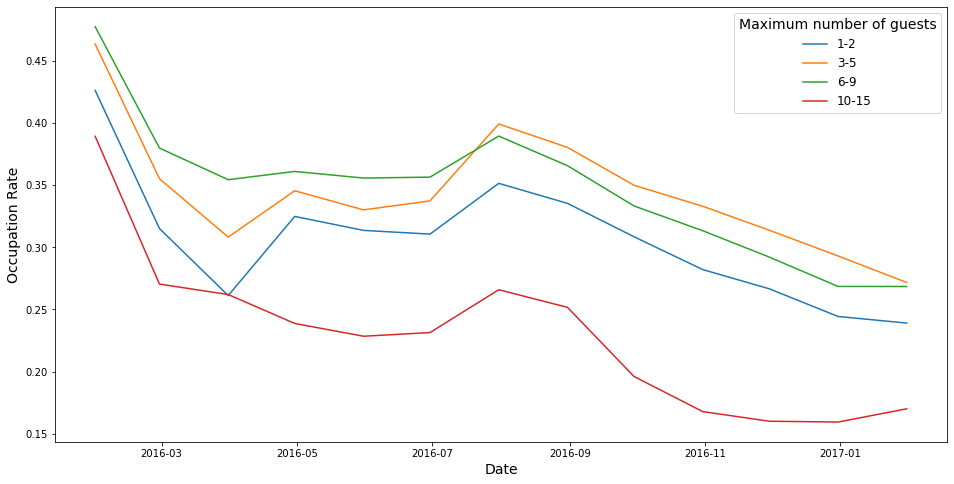

In [236]:
# Occupation rates of rooms with different max accomodates by season

plt.figure(figsize= (16, 8))
room_season_df['Occupation Rate'] = 1 - room_season_df['available_clean']
sns.lineplot(x ='date', y ='Occupation Rate', hue = 'MaxPeopleRange', data = room_season_df)
plt.legend(title = 'Maximum number of guests', fontsize = 12, title_fontsize = 14)
plt.xlabel('Date', fontsize =14)
plt.ylabel('Occupation Rate', fontsize = 14)
plt.savefig('figure4.png')

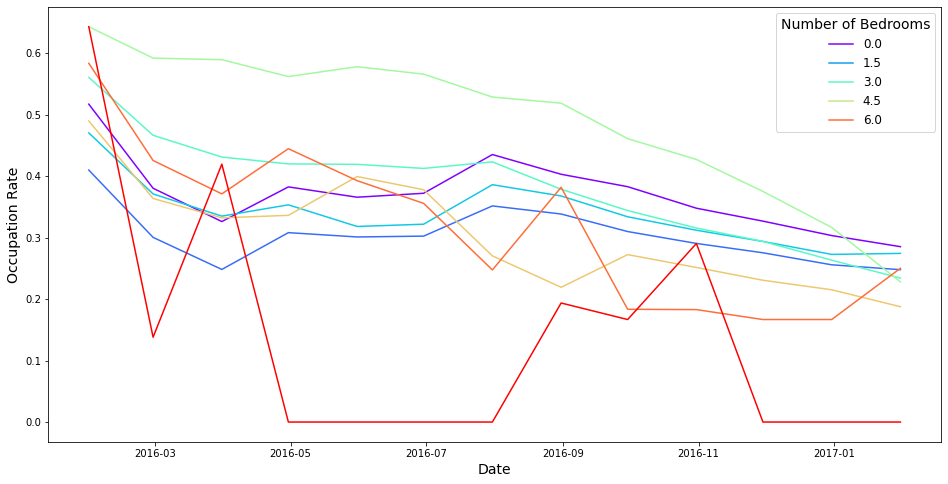

In [238]:
# Occupation rates of rooms by number of rooms and season

plt.figure(figsize= (16, 8))
bedrooms_season_df['Occupation Rate'] = 1 - bedrooms_season_df['available_clean']
sns.lineplot(x ='date', y ='Occupation Rate', hue = 'bedrooms', data = bedrooms_season_df, palette = 'rainbow')
plt.legend(title = 'Number of Bedrooms', fontsize = 12, title_fontsize = 14)
plt.xlabel('Date', fontsize =14)
plt.ylabel('Occupation Rate', fontsize = 14)
plt.savefig('figure5.png')

### Question 3: Number of Competitors

In [ ]:
count_zipcode_df = listings_df[['zipcode', 'id']].groupby('zipcode').count()
count_zipcode_df.reset_index(inplace = True)
count_zipcode_df.columns = ['zipcode', 'count']

#merge countplot with additional info with longitude and latitude
long_lat_df = listings_df[['zipcode', 'longitude', 'latitude']].groupby('zipcode').mean()
count_lat_long_df = count_zipcode_df.merge(long_lat_df, on = 'zipcode')

In [243]:
m = folium.Map([lat, long], zoom_start= 10.5)


folium.Choropleth(
    geo_data=new_zip_json,
    name='choropleth',
    data= count_zipcode_df,
    columns=['zipcode', 'count'],
    key_on='feature.properties.ZIPCODE',
    fill_color= 'YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    nan_fill_color='grey',
    nan_fill_opacity=0.4,
    legend_name= 'Number of Airbnbs by zipcode regions',
).add_to(m)

    
mc = MarkerCluster()
for _, row in count_lat_long_df.iterrows():
    mc.add_child(    
        Marker(location = [row['latitude'], row['longitude']],
               popup='Zipcode {} BnbCount {}'.format(row['zipcode'], row['count'])
              )
    )
    
m.add_child(mc)


m.save('figure6.html')
m

### Extra Analysis: Word Frequency Analysis of neighborhood descriptions and notes by hosts (popular areas)

In [158]:
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer('\w+')

# add new column to reviews_df - comments which are tokenized
listings_df['description_token']=listings_df['description'].apply(regexp.tokenize)

#import stopwords 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")

# Extend the list with your own custom stopwords
my_stopwords = ['https', 'room', 'bed', 'bedroom', 'Seattle', 'space', 'apartment', 'floor', 'kitchen', 'living', 'one', 'bathroom', 'house', 'home', 'guest']
stopwords.extend(my_stopwords)

# remove stop words
listings_df_copy['description_token'] = listings_df_copy['description_token'].apply(lambda x: [item for item in x if item not in stopwords])

#remove infrequent words: keep words longer than two letters
listings_df_copy['description_string'] = listings_df_copy['description_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\younk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#capitol hill description column to one text
capitol_hill_text = ' '.join(description for description in listings_df.loc[listings_df['neighbourhood_group_cleansed'] == 'Capitol Hill', 'description_string'])
capitol_hill_text

#queen anne description column to one text
queen_anne_text = ' '.join(description for description in listings_df.loc[listings_df['neighbourhood_group_cleansed'] == 'Queen Anne', 'description_string'])
queen_anne_text

#cascade description column to one text
cascade_text = ' '.join(description for description in listings_df.loc[listings_df['neighbourhood_group_cleansed'] == 'Cascade', 'description_string'])
cascade_text

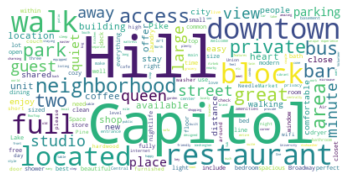

In [160]:
#capitol hill word cloud
capitol_hill_word_cloud = WordCloud(collocations = False, background_color = 'white').generate(capitol_hill_text)
plt.imshow(capitol_hill_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

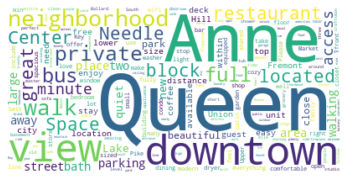

In [161]:
#queen anne word cloud
queen_anne_word_cloud = WordCloud(collocations = False, background_color = 'white').generate(queen_anne_text)
plt.imshow(queen_anne_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

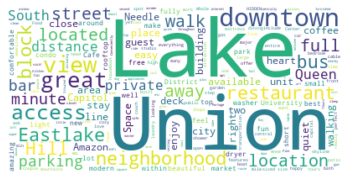

In [164]:
#cascade word cloud
cascade_word_cloud = WordCloud(collocations = False, background_color = 'white').generate(cascade_text)
plt.imshow(cascade_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3. Conclusion and Discussion

Looking out the price and demand for Airbnb rooms across Seattle King County area, we were able to focus on areas that had promising income. Furthermore, checking out the number of potential competitors would have given you additional insights.